Here there is the code to augment the data with all the four techniques discussed in the repo over the train test split saved locally using the same BDLSTM model used for benchmark

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/My Drive/Colab\ Notebooks/AN2DL/Homework2

/gdrive/My Drive/Colab Notebooks/AN2DL/Homework2


# Load data from disck

In [3]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
from tensorflow import keras
!pip install visualkeras
import visualkeras
from datetime import datetime
from random import shuffle
import pickle

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [4]:
BATCH_SIZE = 64
DROPOUT = 0.0
REGULARIZATION = False
PATIENCE = 10

In [5]:
# load plain data split
with open("./train_test_obj", "rb") as f:
  x_train, x_test, y_train, y_test = pickle.load(f)

In [6]:
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(x_test.shape)

(1943, 36, 6)
float64
(1943,)
(486, 36, 6)


In [7]:
print(x_train[0][0], y_train[40:70])
# Add Gaussian noise to the time series
noise = np.random.normal(0, 0.5, 1943*36*6)
noise = noise.reshape(1943, 36, 6)
noisy_data = x_train + noise
x_doubled = np.concatenate((x_train, noisy_data), axis = 0)
y_doubled = np.concatenate((y_train, y_train), axis = 0)
print(y_doubled[40:50])
print(y_doubled[1943+40:1943+50])
print(x_doubled.shape)
print(y_doubled.shape)

[ 2.291     4.5307    3.1934   -0.059906  4.2041   14.324   ] [ 6  0  6  8  3  6  2  9  1  9  3  9  3  9  9  6 10  6  3  6  9 11  6  6
  1  6  3  9  6  6]
[6 0 6 8 3 6 2 9 1 9]
[6 0 6 8 3 6 2 9 1 9]
(3886, 36, 6)
(3886,)


In [8]:
# Scale the time series by multiplying it by 2
scaled_data = x_train * 2
x_tripled = np.concatenate((x_doubled, scaled_data), axis = 0)
y_tripled = np.concatenate((y_doubled, y_train), axis = 0)
print(y_tripled[40:50])
print(y_tripled[1943+40:1943+50])
print(y_tripled[1943*2+40:1943*2+50])
print(x_tripled.shape)
print(y_tripled.shape)

[6 0 6 8 3 6 2 9 1 9]
[6 0 6 8 3 6 2 9 1 9]
[6 0 6 8 3 6 2 9 1 9]
(5829, 36, 6)
(5829,)


In [9]:
# Change the period of the time series by dividing it by 3
periodic_data = x_train / 3
x_quadrupled = np.concatenate((x_tripled, periodic_data), axis = 0)
y_quadrupled = np.concatenate((y_tripled, y_train), axis = 0)
print(y_quadrupled.shape)
print(x_quadrupled.shape)

(7772,)
(7772, 36, 6)


In [10]:
# Rotate the time series by shifting it 10 steps in the future
rotated_data = np.roll(x_train, 10)
x_quintupled = np.concatenate((x_quadrupled, rotated_data), axis = 0)
y_quintupled = np.concatenate((y_quadrupled, y_train), axis = 0)

In [11]:
'''# load scaler
with open("./scaler.p", "rb") as f:
    scaler = pickle.load(f)'''

'# load scaler\nwith open("./scaler.p", "rb") as f:\n    scaler = pickle.load(f)'

# Utils Functions

In [12]:
'''def from_raw_to_dataframe(x_raw, y_raw):
    tabular_list = []
    for i_sample, x in enumerate(x_raw):
        for i_time, xx in enumerate(x):
            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])
    df_res = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
    return df_res'''

"def from_raw_to_dataframe(x_raw, y_raw):\n    tabular_list = []\n    for i_sample, x in enumerate(x_raw):\n        for i_time, xx in enumerate(x):\n            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])\n    df_res = pd.DataFrame(tabular_list).rename(columns={\n        0: 'sample_id',\n        1: 'time',\n        2: 'feat_1',\n        3: 'feat_2',\n        4: 'feat_3',\n        5: 'feat_4',\n        6: 'feat_5',\n        7: 'feat_6',\n        8: 'label'}, inplace=False, errors='raise')\n    return df_res"

In [13]:
'''def build_sequences(df):
    # Sanity check to avoid runtime errors
    #assert window % stride == 0
    dataset = []
    labels = []
    for id in df['sample_id'].unique():
        # Take only meaningful features
        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values
        # Save the label
        label = df[df['sample_id'] == id]['label'].values[0]
        labels.append(label)
        dataset.append(temp)

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels'''

"def build_sequences(df):\n    # Sanity check to avoid runtime errors\n    #assert window % stride == 0\n    dataset = []\n    labels = []\n    for id in df['sample_id'].unique():\n        # Take only meaningful features\n        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values\n        # Save the label\n        label = df[df['sample_id'] == id]['label'].values[0]\n        labels.append(label)\n        dataset.append(temp)\n\n    dataset = np.array(dataset)\n    labels = np.array(labels)\n    return dataset, labels"

In [14]:
'''def normalize_data_feature_wise(x_original, y_original, max_value=1, quantile=False):
    x_original_tabular = from_raw_to_dataframe(x_original, y_original)
    if quantile:
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler(feature_range=(0, max_value))
    scaler.fit_transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
    x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(
        x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])

    agg_x, agg_y = build_sequences(x_original_tabular)
    return agg_x, agg_y, scaler'''

"def normalize_data_feature_wise(x_original, y_original, max_value=1, quantile=False):\n    x_original_tabular = from_raw_to_dataframe(x_original, y_original)\n    if quantile:\n        scaler = RobustScaler()\n    else:\n        scaler = MinMaxScaler(feature_range=(0, max_value))\n    scaler.fit_transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])\n    x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(\n        x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])\n\n    agg_x, agg_y = build_sequences(x_original_tabular)\n    return agg_x, agg_y, scaler"

In [15]:
'''def apply_scaler_to_new_data(x,y,scaler):
  x_original_tabular = from_raw_to_dataframe(x, y)
  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
  agg_x, agg_y = build_sequences(x_original_tabular)
  return agg_x, agg_y'''

"def apply_scaler_to_new_data(x,y,scaler):\n  x_original_tabular = from_raw_to_dataframe(x, y)\n  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])\n  agg_x, agg_y = build_sequences(x_original_tabular)\n  return agg_x, agg_y"

# Data processing

In [16]:
'''x_train_norm, y_train_norm = apply_scaler_to_new_data(x_train, y_train, scaler)
x_test_norm, y_test_norm = apply_scaler_to_new_data(x_test, y_test, scaler)'''

train_dataset = tf.data.Dataset.from_tensor_slices((x_quintupled, y_quintupled)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Weights

In [17]:
# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight
NUM_CLASSES = 12
def get_class_weight(y):
    total_samples = len(y)
    class_weight = {}
    for i in range(NUM_CLASSES):
        class_weight[i] = 1 - (np.bincount(y)[i] / total_samples)
    return class_weight

#class_weight = get_class_weight(y_train_norm)
#class_weight

# Model Usage

## 1DConv

In [18]:
def Conv1D_BN_ReLu_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## LSTM

In [19]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer) #Number of neurons means dimension of the cell
    #Return sequences is a parameter that decides to return each timestep output or only the final one (False)
    lstm = tfkl.LSTM(32)(lstm)
    dropout = tfkl.Dropout(DROPOUT, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

## Bidrectional LSTM

In [20]:
from tensorflow.keras import regularizers

def bidirectional_LSTM(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(input_layer)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
    if REGULARIZATION:
        x = keras.layers.Dense(32, kernel_regularizer=regularizers.l2(REGULARIZING_FACTOR), activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## CNN from Lab

In [21]:
def CC_from_Lab(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# Choose Model

In [22]:
model = bidirectional_LSTM((x_train.shape[1], x_train.shape[2]))
#model = CC_from_Lab((x_train_norm.shape[1], x_train_norm.shape[2]))
#model = Conv1D_BN_ReLu_model((x_train_norm.shape[1], x_train_norm.shape[2]))
#model = build_LSTM_classifier((x_train_norm.shape[1], x_train_norm.shape[2]), NUM_CLASSES)

In [23]:
'''# callback list
callbacks_list = []
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=40, restore_best_weights=True)
callbacks_list.append(es_callback)'''

callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy', 
            patience = PATIENCE, 
            verbose=1,
            restore_best_weights=True
        ),
    ]

model.compile(
    optimizer= keras.optimizers.Adam(),
    #loss="sparse_categorical_crossentropy",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_dataset,
    epochs=200,
    callbacks=callbacks,
    validation_data= test_dataset,
    verbose=1,
    #class_weight=class_weight,
)

Epoch 1/200
152/152 [==============================] - 35s 139ms/step - loss: 1.8270 - sparse_categorical_accuracy: 0.4237 - val_loss: 1.7051 - val_sparse_categorical_accuracy: 0.4527
Epoch 2/200
152/152 [==============================] - 10s 66ms/step - loss: 1.3661 - sparse_categorical_accuracy: 0.5399 - val_loss: 1.4034 - val_sparse_categorical_accuracy: 0.5226
Epoch 3/200
152/152 [==============================] - 10s 64ms/step - loss: 1.1623 - sparse_categorical_accuracy: 0.6024 - val_loss: 1.3625 - val_sparse_categorical_accuracy: 0.5082
Epoch 4/200
152/152 [==============================] - 10s 66ms/step - loss: 1.0255 - sparse_categorical_accuracy: 0.6529 - val_loss: 1.2831 - val_sparse_categorical_accuracy: 0.5247
Epoch 5/200
152/152 [==============================] - 10s 64ms/step - loss: 0.9139 - sparse_categorical_accuracy: 0.6858 - val_loss: 1.3256 - val_sparse_categorical_accuracy: 0.5391
Epoch 6/200
152/152 [==============================] - 10s 65ms/step - loss: 0.8292 

In [24]:
#model = keras.models.load_model("./Fully_Convolutional_Neural_Network/")
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print("\n")
print("Test accuracy", test_acc)
print("Test loss", test_loss)

8/8 - 0s - loss: 1.4565 - sparse_categorical_accuracy: 0.5617 - 153ms/epoch - 19ms/step


Test accuracy 0.5617284178733826
Test loss 1.4565250873565674


In [25]:
# Predict the test set 
predictions = model.predict(test_dataset)

8/8 [==============================] - 2s 18ms/step


In [26]:
import sklearn
from sklearn.metrics import confusion_matrix
f1_score = sklearn.metrics.f1_score(y_test, predictions.argmax(axis=1), average='macro')
print("F1 score", f1_score)

F1 score 0.3889973734147214


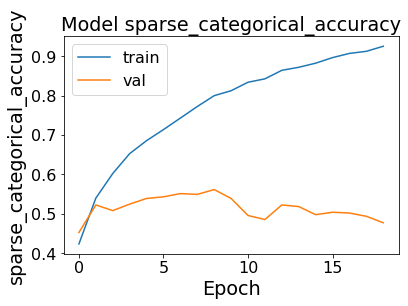

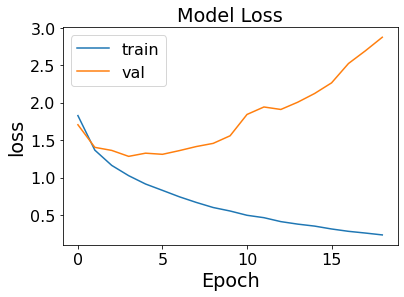

In [27]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Plot the loss function
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

In [28]:
Classes = ["Wish", "Another", "Comfortably", "Money", "Breathe", "Time", "Brain", "Echoes", "Wearing", "Sorrow", "Hey", "Shine"]

Normalized confusion matrix
[[0.         0.         0.         0.         0.         0.
  0.25       0.         0.25       0.         0.         0.5       ]
 [0.         0.31818182 0.         0.36363636 0.         0.
  0.         0.         0.         0.31818182 0.         0.        ]
 [0.         0.02222222 0.84444444 0.         0.         0.
  0.02222222 0.         0.         0.         0.11111111 0.        ]
 [0.         0.10843373 0.01204819 0.40963855 0.         0.02409639
  0.03614458 0.         0.01204819 0.38554217 0.         0.01204819]
 [0.         0.         0.         0.07692308 0.         0.15384615
  0.         0.         0.         0.76923077 0.         0.        ]
 [0.         0.21875    0.         0.21875    0.         0.125
  0.09375    0.         0.         0.34375    0.         0.        ]
 [0.         0.04347826 0.04347826 0.02898551 0.         0.
  0.71014493 0.         0.01449275 0.11594203 0.04347826 0.        ]
 [0.         0.125      0.         0.625      0.  

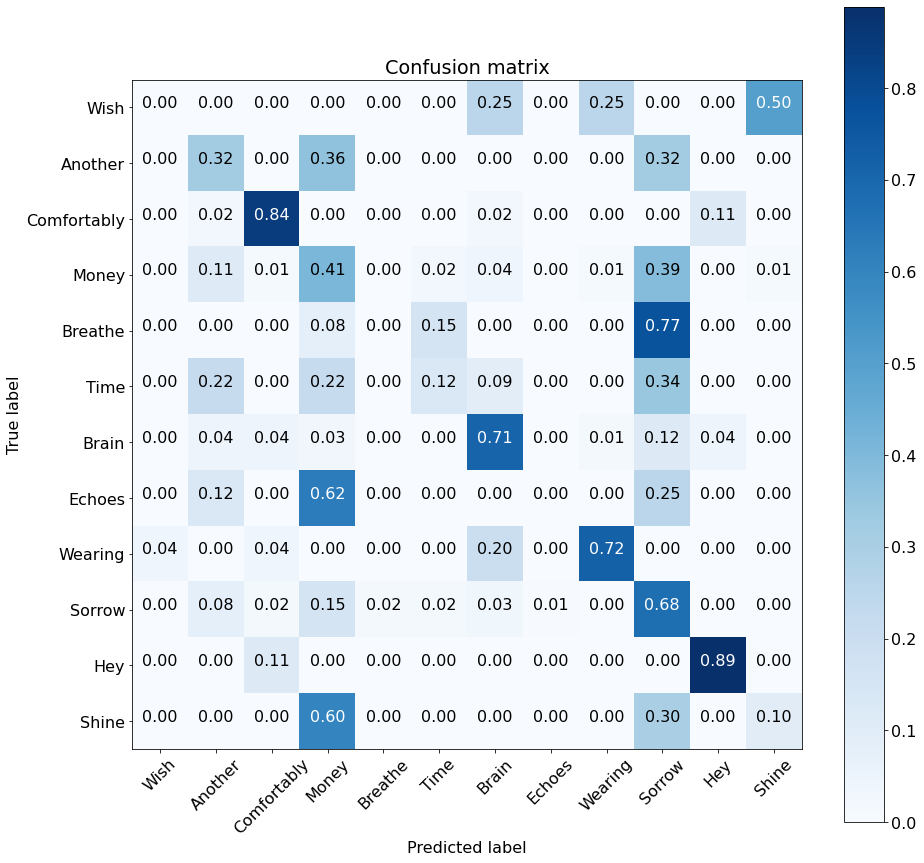

In [29]:
# Funtion that plots the confusion matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(confusion_matrix(y_test, predictions.argmax(axis=1)), classes=Classes, normalize=True) 

In [30]:
# Print recall, precision, specificity, accuracy, F1 score
def print_metrics(y_true, y_pred):
    print("Recall: ", recall_score(y_true, y_pred, average='macro'))
    #print("Precision: ", precision_score(y_true, y_pred, average='macro'))
    print("Specificity: ", recall_score(y_true, y_pred, average='macro'))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    
    
print_metrics(y_test, predictions.argmax(axis=1))

Recall:  0.39928815574475335
Specificity:  0.39928815574475335
Accuracy:  0.5617283950617284
